1, 7, 9, 10

In [23]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

### 1

It was mentioned in this chapter that a cubic regression spline with one knot at ξ can be obtained using a basis of the form $x, x^2 , x^3 , (x − ξ)^3+$ , where $(x − ξ)^3+ = (x − ξ)^3$ if $x > ξ$ and equals 0 otherwise. We will now show that a function of the form $f(x) = β_0 + β_1x + β_2x^2 + β_3x^3 + β_4(x − ξ)^3+$ is indeed a cubic regression spline, regardless of the values of $β0 , β1 ,β2 ,β3 , β4$ .

(a) Find a cubic polynomial $f1(x) = a_1 + b_1x + c_1x^2 + d_1x^3$ such that $f(x) = f_1(x)$ for all $x ≤ ξ$. Express $a_1 , b_1 , c_1 , d_1$ in terms of $β0 , β1 , β2 , β3 , β4$.

answer: $a_1 = β_0, b_1 = β_1, c_1 = β_2, d_1 = β_3$ (since $(x - \xi)^3+ = 0$ for $x \leq \xi$)

(b) Find a cubic polynomial $f_2(x) = a_2 + b_2x + c_2x^2 + d_2x^3$ such that $f(x) = f_2(x) for all $x > ξ$. Express $a_2 , b_2 , c_2 , d_2$ in terms of $β0 , β 1 , β2, β3 , β4$ . We have now established that $f(x)$ is a piecewise polynomial.

answer: $a_2 = β_0 + β_4, b_2 = β_1, c_2 = β_2, d_2 = β_3$ (since $(x - \xi)^3+ = (x - \xi)^3$ for $x > \xi$)

(c) Show that $f_1(ξ) = f_2(ξ)$. That is, $f(x)$ is continuous at $ξ$.

answer: $f_1(\xi) = a_1 + b_1\xi + c_1\xi^2 + d_1\xi^3 = β_0 + β_1\xi + β_2\xi^2 + β_3\xi^3 = β_0 + β_4 + β_1\xi + β_2\xi^2 + β_3\xi^3 = a_2 + b_2\xi + c_2\xi^2 + d_2\xi^3 = f_2(\xi)$

(d) Show that $f_1'(ξ) = f_2'(ξ)$. That is, $f'(x)$ is continuous at $ξ$.

answer: $f_1'(\xi) = b_1 + 2c_1\xi + 3d_1\xi^2 = β_1 + 2β_2\xi + 3β_3\xi^2 = β_1 + 2β_2\xi + 3β_3\xi^2 = β_1 + 2β_2\xi + 3β_3\xi^2 = β_1 + 2β_2\xi + 3β_3\xi^2 = β_1 + 2β_2\xi + 3β_3\xi^2 = b_2 + 2c_2\xi + 3d_2\xi^2 = f_2'(\xi)$

(e) Show that $f_1''(ξ) = f_2(ξ)''$. That is, $f''(x)$ is continuous at $ξ$.

Therefore, f (x) is indeed a cubic spline.

Hint: Parts (d) and (e) of this problem require knowledge of single-
variable calculus. As a reminder, given a cubic polynomial

$f_1(x) = a_1 + b_1x + c_1x^2 + d_1x^3$ ,

the first derivative takes the form

$f1'(x) = b_1 + 2c_1x + 3d_1x^2$

and the second derivative takes the form

$f1''(x) = 2c_1 + 6d_1x$.

### 7

The Wage data set contains a number of other features not explored
in this chapter, such as marital status (maritl), job class (jobclass),
and others. Explore the relationships between some of these other
predictors and wage, and use non-linear fitting techniques in order to
fit flexible models to the data. Create plots of the results obtained,
and write a summary of your findings.

In [38]:
wage_data = load_data('Wage')
wage_data.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [39]:
# check and clean na
wage_data.isna().sum()

year          0
age           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64

In [40]:
# map categorical to numerical for education and health and health ins
wage_data['education'] = wage_data['education'].map({'1. < HS Grad': 1,
                                                     '2. HS Grad': 2,
                                                     '3. Some College': 3,
                                                     '4. College Grad': 4,
                                                     '5. Advanced Degree': 5})
wage_data['health'] = wage_data['health'].map({'1. <=Good': 1,
                                                  '2. >=Very Good': 2})
wage_data['health_ins'] = wage_data['health_ins'].map({'1. Yes': 1,
                                                       '2. No': 0})

I am operating on the assumption that education can be interpreted as ordinal i.e. higher education levels should have a higher value than lower education levels.

In [41]:
# one hot encoding for maritl, race, region, jobclass
wage_data = pd.get_dummies(wage_data, columns=['maritl','race', 'region', 'jobclass'], drop_first=True)

In [42]:
wage_data.head()

,year,age,education,health,health_ins,logwage,wage,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_2. Black,race_3. Asian,race_4. Other,jobclass_2. Information
0,2006,18,1,1,0,4.318063,75.043154,0,0,0,0,0,0,0,0
1,2004,24,4,2,0,4.255273,70.476020,0,0,0,0,0,0,0,1
2,2003,45,3,1,1,4.875061,130.982177,1,0,0,0,0,0,0,0
3,2003,43,4,2,1,5.041393,154.685293,1,0,0,0,0,1,0,1
4,2005,50,2,1,1,4.318063,75.043154,0,0,1,0,0,0,0,1


### 9

This question uses the variables dis (the weighted mean of distances
to five Boston employment centers) and nox (nitrogen oxides concen-
tration in parts per 10 million) from the Boston data. We will treat
dis as the predictor and nox as the response.

In [15]:
boston_data = load_data('Boston')
boston_data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


| Variable | Description |
|----------|-------------|
| crim     | Per capita crime rate by town. |
| zn       | Proportion of residential land zoned for lots over 25,000 sq.ft. |
| indus    | Proportion of non-retail business acres per town. |
| chas     | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise). |
| nox      | Nitrogen oxides concentration (parts per 10 million). |
| rm       | Average number of rooms per dwelling. |
| age      | Proportion of owner-occupied units built prior to 1940. |
| dis      | Weighted mean of distances to five Boston employment centres. |
| rad      | Index of accessibility to radial highways. |
| tax      | Full-value property-tax rate per $10,000. |
| ptratio  | Pupil-teacher ratio by town. |
| lstat    | Lower status of the population (percent). |
| medv     | Median value of owner-occupied homes in $1000s. |


(a) Use the poly() function from the ISLP.models module to fit a
cubic polynomial regression to predict nox using dis. Report the
regression output, and plot the resulting data and polynomial
fits.

/home/jake/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


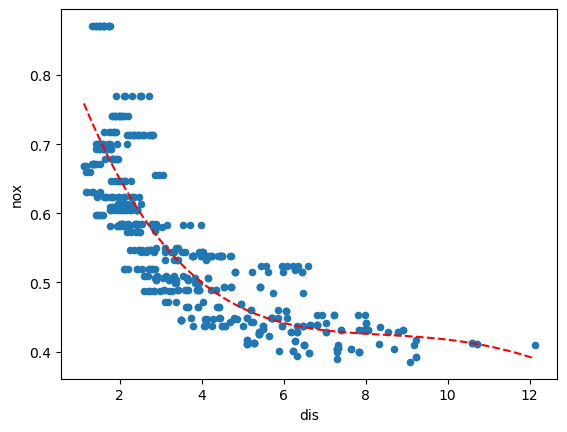

In [3]:
y = boston_data['nox']
poly_dis = MS([poly('dis', degree=4)]).fit(boston_data)
M = sm.OLS(y, poly_dis.transform(boston_data)).fit()
summarize(M)

# plot
fig, ax = subplots()
boston_data.plot.scatter('dis', 'nox', ax=ax)
x = np.linspace(boston_data['dis'].min(), boston_data['dis'].max(), 100)
ax.plot(x, M.predict(poly_dis.transform(pd.DataFrame({'dis': x}))), 'r--')

(b) Plot the polynomial fits for a range of different polynomial
degrees (say, from 1 to 10), and report the associated residual
sum of squares.

/home/jake/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


{1: 2.768562858969277,
 2: 2.035261868935256,
 3: 1.9341067071790703,
 4: 1.9329813272985947,
 5: 1.9152899610843046,
 6: 1.878257298508164,
 7: 1.8494836145829783,
 8: 1.8356296890676884,
 9: 1.8333308044915941,
 10: 1.832171123931342}

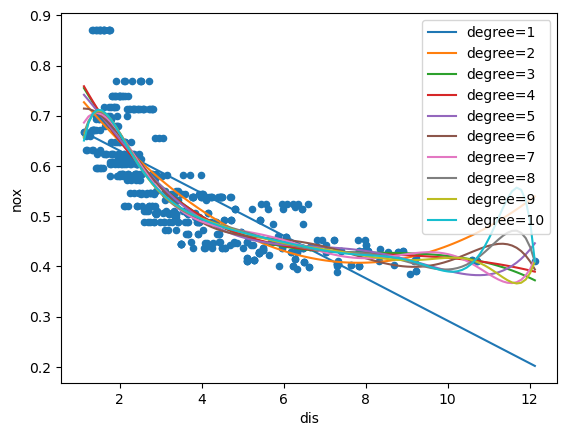

In [4]:
fig, ax = subplots()
boston_data.plot.scatter('dis', 'nox', ax=ax)
x = np.linspace(boston_data['dis'].min(), boston_data['dis'].max(), 100)
for degree in range(1, 11):
    poly_dis = MS([poly('dis', degree=degree)]).fit(boston_data)
    M = sm.OLS(y, poly_dis.transform(boston_data)).fit()
    ax.plot(x, M.predict(poly_dis.transform(pd.DataFrame({'dis': x}))), label=f'degree={degree}')
ax.legend()

# report residual sum of squares for each degree
degrees_rss = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
for degree in range(1, 11):
    poly_dis = MS([poly('dis', degree=degree)]).fit(boston_data)
    M = sm.OLS(y, poly_dis.transform(boston_data)).fit()
    degrees_rss[degree] = M.ssr
degrees_rss

(c) Perform cross-validation or another approach to select the opti-
mal degree for the polynomial, and explain your results.

In [5]:
# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

degrees = np.arange(1, 11)
deg_rss = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
for degree in degrees:
    poly_dis = MS([poly('dis', degree=degree)]).fit(boston_data)
    M = sm.OLS(y, poly_dis.transform(boston_data)).fit()
    lr = LinearRegression()
    scores = cross_val_score(lr, poly_dis.transform(boston_data), y, cv=5, scoring='neg_mean_squared_error')
    deg_rss[degree] = -scores.mean()
deg_rss
# lowest
min(deg_rss, key=deg_rss.get)

2

(d) Use the bs() function from the ISLP.models module to fit a re-
gression spline to predict nox using dis. Report the output for
the fit using four degrees of freedom. How did you choose the
knots? Plot the resulting fit.

/home/jake/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


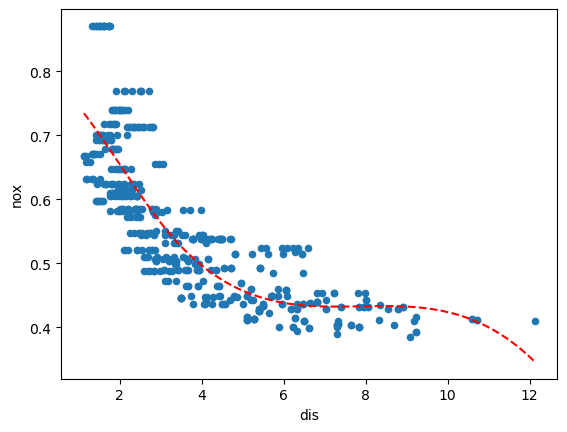

In [6]:
# bs = BSpline('dis', df=4)
bs_dis = MS([bs('dis', df=4)]).fit(boston_data)
M = sm.OLS(y, bs_dis.transform(boston_data)).fit()
summarize(M)

# plot
fig, ax = subplots()
boston_data.plot.scatter('dis', 'nox', ax=ax)
x = np.linspace(boston_data['dis'].min(), boston_data['dis'].max(), 100)
ax.plot(x, M.predict(bs_dis.transform(pd.DataFrame({'dis': x}))), 'r--')

The knots were chosen using the 4 degree of freedom.

(e) Now fit a regression spline for a range of degrees of freedom, and
plot the resulting fits and report the resulting RSS. Describe the
results obtained.

/home/jake/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


{3: 1.9341067071790705,
 4: 1.9227749928119255,
 5: 1.840172801488524,
 6: 1.8339659031602096,
 7: 1.8298844459232844,
 8: 1.8169950567252333,
 9: 1.8256525103870562}

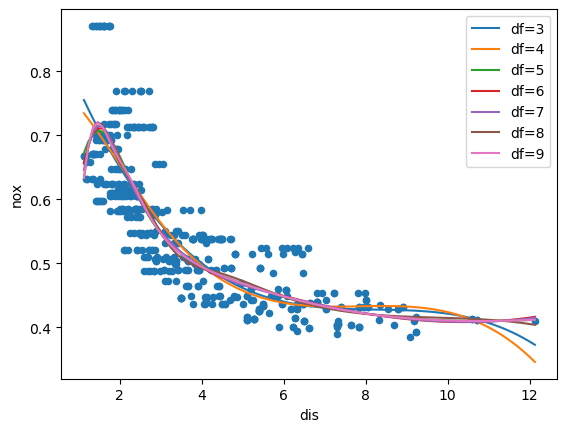

In [9]:
# plot
fig, ax = subplots()
boston_data.plot.scatter('dis', 'nox', ax=ax)
x = np.linspace(boston_data['dis'].min(), boston_data['dis'].max(), 100)
for df in range(3, 10):
    bs_dis = MS([bs('dis', df=df)]).fit(boston_data)
    M = sm.OLS(y, bs_dis.transform(boston_data)).fit()
    ax.plot(x, M.predict(bs_dis.transform(pd.DataFrame({'dis': x}))), label=f'df={df}')
ax.legend()

# rss
df_rss = {3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for df in range(3, 10):
    bs_dis = MS([bs('dis', df=df)]).fit(boston_data)
    M = sm.OLS(y, bs_dis.transform(boston_data)).fit()
    df_rss[df] = M.ssr
df_rss
# lowest
# min(df_rss, key=df_rss.get)

(f) Perform cross-validation or another approach in order to select
the best degrees of freedom for a regression spline on this data.
Describe your results.

In [13]:
df_rss = {3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for df in range(3, 10):
    bs_dis = MS([bs('dis', df=df)]).fit(boston_data)
    M = sm.OLS(y, bs_dis.transform(boston_data)).fit()
    lr = LinearRegression()
    scores = cross_val_score(lr, bs_dis.transform(boston_data), y, cv=5, scoring='neg_mean_squared_error')
    df_rss[df] = -scores.mean()
df_rss

# lowest
# print(min(df_rss, key=df_rss.get))

{3: 0.004647367459422965,
 4: 0.005179168982316173,
 5: 0.004788388358923629,
 6: 0.005227434315356486,
 7: 0.005209741820397007,
 8: 0.005544683680053567,
 9: 0.005293458502480565}

### 10

This question relates to the College data set.

In [18]:
college_data = load_data('College')
college_data.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [20]:
# encode private yes/no to 1/0
college_data['Private'] = college_data['Private'].map({'Yes': 1, 'No': 0})

(a) Split the data into a training set and a test set. Using out-of-state
tuition as the response and the other variables as the predictors,
perform forward stepwise selection on the training set in order
to identify a satisfactory model that uses just a subset of the
predictors.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

X = college_data.drop(columns=['Outstate'])
y = college_data['Outstate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# forward stepwise selection
def forward_stepwise_selection(X, y, n_features):
    features = []
    for i in range(n_features):
        best_feature = None
        best_score = 0
        for feature in X.columns:
            if feature in features:
                continue
            lr = LinearRegression()
            lr.fit(X[features + [feature]], y)
            score = f_regression(X[features + [feature]], y)[0][0]
            if score > best_score:
                best_score = score
                best_feature = feature
        features.append(best_feature)
    return features

forward_stepwise_selection(X_train, y_train, 5)

['Expend', 'Private', 'Apps', 'Accept', 'Enroll']

(b) Fit a GAM on the training data, using out-of-state tuition as
the response and the features selected in the previous step as
the predictors. Plot the results, and explain your findings.

Text(0, 0.5, 'Outstate')

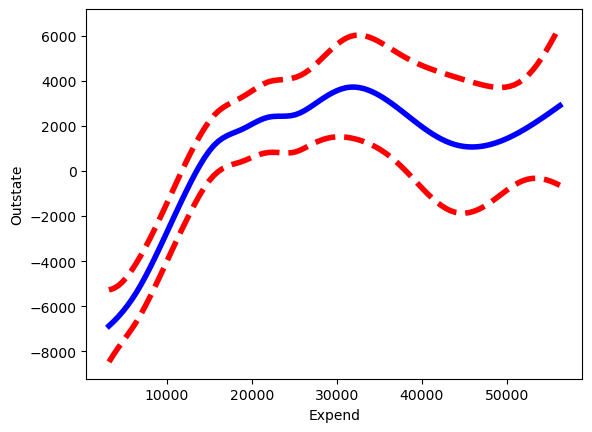

In [33]:
# fit a GAM
X_train_selected = X_train[['Expend', 'Private', 'Apps', 'Accept', 'Enroll']]
X_test_selected = X_test[['Expend', 'Private', 'Apps', 'Accept', 'Enroll']]
gam = LinearGAM(s_gam(0) + l_gam(1) + l_gam(2) + l_gam(3) + l_gam(4)).fit(X_train_selected, y_train)

# plot
fig, ax = subplots()
plot_gam(gam, 0, ax=ax)
ax.set_xlabel('Expend')
ax.set_ylabel('Outstate')

(c) Evaluate the model obtained on the test set, and explain the
results obtained.

In [35]:
# evaluate
y_pred = gam.predict(X_test_selected)
rss = ((y_test - y_pred) ** 2).sum()
rmse = np.sqrt(rss / len(y_test))
rmse

2279.2104210104358

(d) For which variables, if any, is there evidence of a non-linear
relationship with the response?

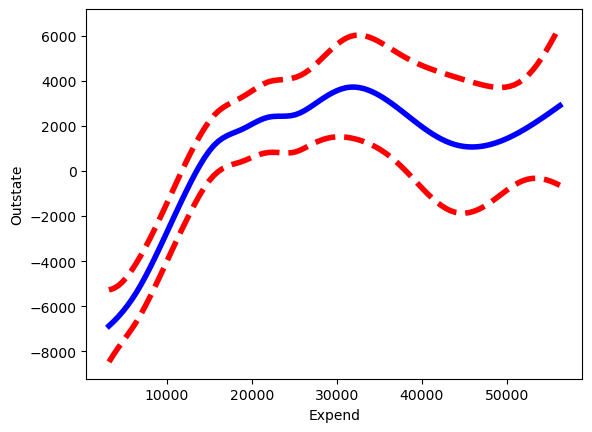

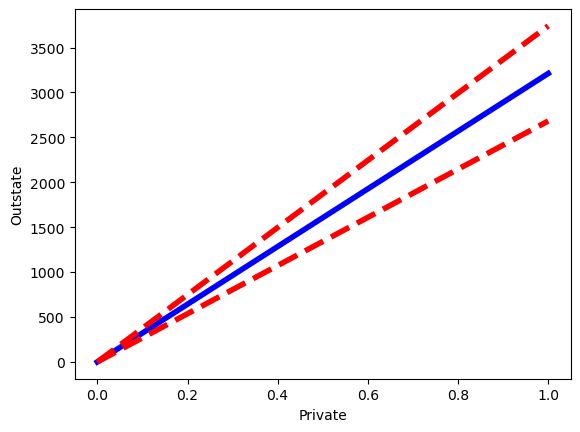

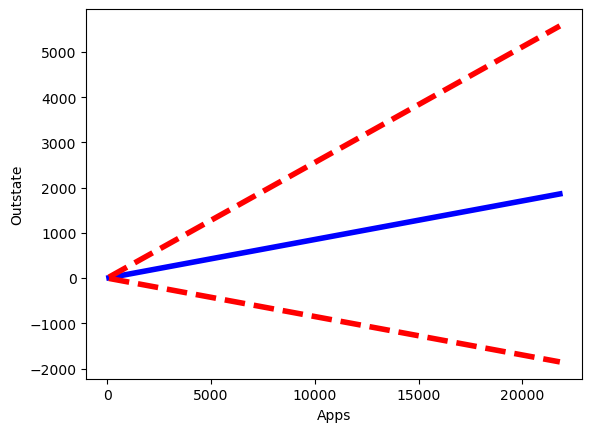

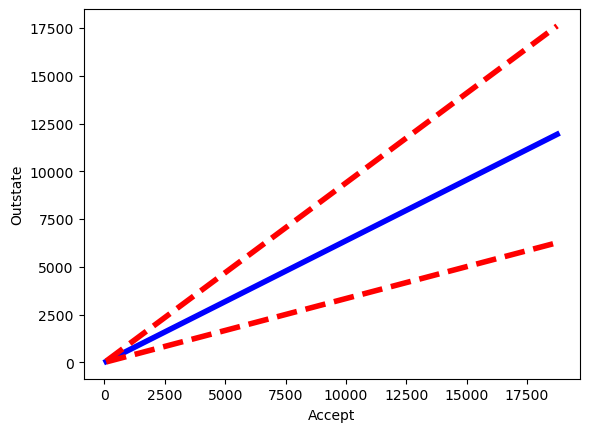

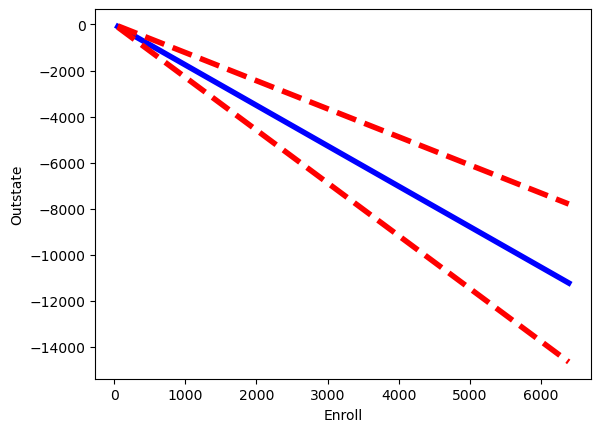

In [37]:
# (d) For which variables, if any, is there evidence of a non-linear
# relationship with the response?

# plot 
for i, feature in enumerate(X_train_selected.columns):
    fig, ax = subplots()
    plot_gam(gam, i, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Outstate')